# Overview
Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

* **Target**: In this competition, we will develop models that identify and flag insincere questions.
* **Data**: The training data includes the question that was asked, and whether it was identified as insincere (target = 1). For each qid in the test set, we must predict whether the corresponding question_text is insincere (1) or not (0). 
* **Evaluation metrics**:Submissions are evaluated on F1 Score between the predicted and the observed targets.

# Import and Clean the data
 There are 1,306,122 entries in the training set and 375,806 entries in the test set. In the training data the insincere quetions  accout for 1/10 of all the questions. 

In [1]:
import numpy as np
import pandas as pd

train_df=pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df=pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
train_df.sample(5)

,qid,question_text,target
394905,4d5fcc7ab896b6dde80d,What would happen if all individual minds are ...,0
694206,87fa0dbd94d15a482ad4,Is NCERT alone enough to score 100+ in chemistry?,0
78757,0f6aade84a72400dd0c8,Which are the automation colleges in Karnataka?,0
766006,96114e5881b0591bffef,Who do you think is going to benefit the most ...,0
18915,03b456e37e67ba9d504f,Why do black women cause a majority of public ...,1


In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


(array([1225312.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   80810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

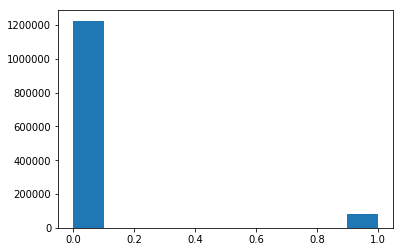

In [3]:
import matplotlib.pyplot as plt
plt.hist(train_df.target)

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
qid              375806 non-null object
question_text    375806 non-null object
dtypes: object(2)
memory usage: 5.7+ MB


Replace the sepecial symbols by space, convert the string into lowercase and fill the missing values with "_na_"

In [5]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' ')
    return x

def preprocess(df,col):
    df[col] = df[col].str.lower()
    df[col] = df[col].apply(lambda x: clean_text(x))
    df[col] = df[col].fillna("_na_")
    
preprocess(train_df,"question_text")
preprocess(test_df,"question_text")

Split the training set into train and validate set.

In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2008)
x_train = train_df["question_text"].values
x_val = val_df["question_text"].values
x_test = test_df["question_text"].values

Most of the questons have less than 200 words and the median of the length is around 70 words. Let us set the max length of the question as 80. 

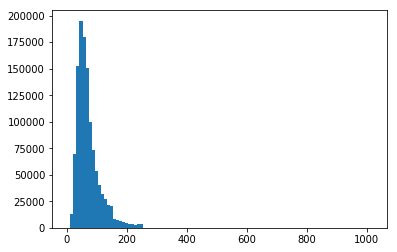

In [7]:
import matplotlib.pyplot as plt
plt.hist([len(item) for item in x_train],bins=100)
plt.show()

# Tokenize the text

Use  Keras to tokenzie the text,  then convert the lists of tokens into sequece. There are 185,320 unique tokens in the train text. I use the top 100,000 words as features by setting MAX_WORDS as 100,000. Since all the pretrained embeddings have  300 dimensions, I set the embedding size as 300.

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAXLEN=80 # cuts off the text after 100 words
MAX_WORDS=100000 # consider only the top 100,000 words as features
EMBEDDING_DIM=300 # The dimension of the embeddings

tokenizer=Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)
word_index=tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

sequences_train=tokenizer.texts_to_sequences(x_train)
x_train_2d=pad_sequences(sequences_train,maxlen=MAXLEN)

sequences_val=tokenizer.texts_to_sequences(x_val)
x_val_2d=pad_sequences(sequences_val,maxlen=MAXLEN)

sequences_test=tokenizer.texts_to_sequences(x_test)
x_test_2d=pad_sequences(sequences_test,maxlen=MAXLEN)

y_train=train_df['target'].values
y_val=val_df['target'].values

Using TensorFlow backend.


Found 185320 unique tokens.


#  Load pretrained embeddings
Four pretrianed embeddings are available to use in this competition.

In [9]:
!ls ../input/quora-insincere-questions-classification/embeddings/

GoogleNews-vectors-negative300	paragram_300_sl999
glove.840B.300d			wiki-news-300d-1M


Import Glove, Fasttext and Para embeddings. 

In [10]:
EMBEDDING_FILE_Glove='../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt'
EMBEDDING_FILE_Fasttext='../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
EMBEDDING_FILE_Para='../input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt'

def load_embeddings(EMBEDDING_FILE,word_index):

    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')    
    
    if EMBEDDING_FILE==EMBEDDING_FILE_Glove:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    elif EMBEDDING_FILE==EMBEDDING_FILE_Fasttext:
        embeddings_index = dict(get_coefs(*o.split(' ')) for o in open(EMBEDDING_FILE) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(' ')) for o in open(EMBEDDING_FILE, encoding='utf8', errors='ignore') if len(o)>100)
    print ('Found %s word vectors' % len(embeddings_index))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embeddings_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (MAX_WORDS,embeddings_size))#generate the embedding max with normal distribution 
    for word, i in word_index.items():
        if i >= MAX_WORDS: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector# words not found in the embedding index will remain the initial values
    
    return embedding_matrix

embeddings_matrix_glove=load_embeddings(EMBEDDING_FILE_Glove,word_index)
embeddings_matrix_fasttext=load_embeddings(EMBEDDING_FILE_Fasttext,word_index)
embeddings_matrix_para=load_embeddings(EMBEDDING_FILE_Para,word_index)

Found 2196016 word vectors


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Found 999994 word vectors
Found 1703755 word vectors


# Prepare for the model
**The attention mechanism** to overcome the limitation that allows the network to learn where to pay attention in the input sequence for each item in the output sequence.

In [11]:
from keras.engine.topology import Layer
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


## Build the model with LSTM and Attention
Since we don't care the direction of the quesitons, we will use the bidrectional LSTM and Attention layes to build the model. The construction of my NN model is as following.

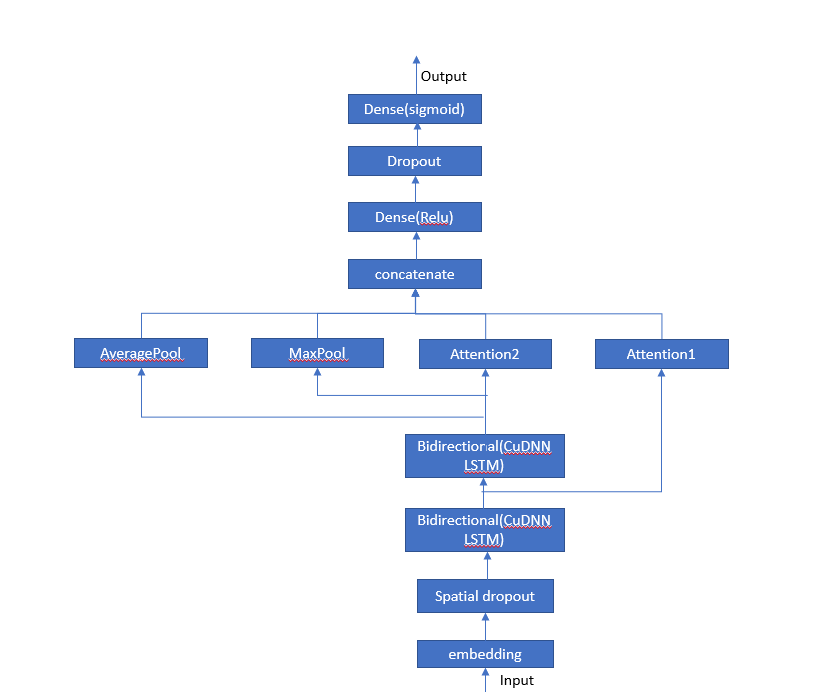

In [12]:
from IPython.display import Image
Image("../input/picture/NN.png")

In [13]:
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate, Lambda
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate

def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(MAXLEN,))
    x = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(0.1)(x)
    x = Bidirectional(CuDNNLSTM(40, return_sequences=True))(x)
    y = Bidirectional(CuDNNGRU(40, return_sequences=True))(x)
    
    atten_1 = Attention(MAXLEN)(x)
    atten_2 = Attention(MAXLEN)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    conc = Dense(16, activation='relu')(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation='sigmoid')(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

# Fit and predict

Fit the model with glove embeddings and predict the validation set. Print f1 score corrsponding to thresh from 0.1 to 0.501. 

In [14]:
from sklearn import metrics
model_glove=model_lstm_atten(embeddings_matrix_glove)
model_glove.fit(x_train_2d,y_train,
                   epochs=3,
                   batch_size=512,
                   validation_data=(x_val_2d, y_val))
pred_val_glove = model_glove.predict([x_val_2d], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_val_glove>thresh).astype(int))))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 104s 88us/step - loss: 0.1199 - acc: 0.9537 - val_loss: 0.1043 - val_acc: 0.9578
Epoch 2/3
1175509/1175509 [==============================] - 101s 86us/step - loss: 0.1046 - acc: 0.9588 - val_loss: 0.1002 - val_acc: 0.9598
Epoch 3/3
130613/130613 [==============================] - 3s 22us/step
F1 score at threshold 0.1 is 0.6166983761780452
F1 score at threshold 0.11 is 0.6249660295316605
F1 score at threshold 0.12 is 0.6308879951925299
F1 score at threshold 0.13 is 0.6369030799660921
F1 score at threshold 0.14 is 0.6432102913646618
F1 score at threshold 0.15 is 0.6474089977554406
F1 score at threshold 0.16 is 0.6522148916116871
F1 score at threshold 0.17 is 0.6564562446470855
F1 score at threshold 0.18 is 0.6603271983640082
F1 score at threshold 0.19 is 0.6635499454573788
F1 score at threshold 0.2 is 0.6661043753294675
F1 score at threshold 0.21 is 0.6692661040487128
F1 sc

In [15]:
pred_test_glove = model_glove.predict([x_test_2d], batch_size=1024, verbose=1)
del embeddings_matrix_glove, model_glove
import gc; gc.collect()


375806/375806 [==============================] - 8s 20us/step


125

Fit the model with para embeddings and predict the validation set. Print f1 score corresponding to thresh from 0.1 to 0.501. 

In [16]:
model_para=model_lstm_atten(embeddings_matrix_para)
model_para.fit(x_train_2d,y_train,
                   epochs=3,
                   batch_size=512,
                   validation_data=(x_val_2d, y_val))
pred_val_para = model_para.predict([x_val_2d], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_val_para>thresh).astype(int))))


Train on 1175509 samples, validate on 130613 samples
Epoch 1/3
1175509/1175509 [==============================] - 101s 86us/step - loss: 0.1231 - acc: 0.9527 - val_loss: 0.1067 - val_acc: 0.9573
Epoch 2/3
1175509/1175509 [==============================] - 101s 86us/step - loss: 0.1062 - acc: 0.9581 - val_loss: 0.1035 - val_acc: 0.9589
Epoch 3/3
130613/130613 [==============================] - 3s 22us/step
F1 score at threshold 0.1 is 0.6192902638762511
F1 score at threshold 0.11 is 0.626044180434379
F1 score at threshold 0.12 is 0.6319519916835987
F1 score at threshold 0.13 is 0.6372039283651069
F1 score at threshold 0.14 is 0.6428396812203588
F1 score at threshold 0.15 is 0.6478523955956751
F1 score at threshold 0.16 is 0.6518786781349026
F1 score at threshold 0.17 is 0.654436120878561
F1 score at threshold 0.18 is 0.6576446280991735
F1 score at threshold 0.19 is 0.6601160298959912
F1 score at threshold 0.2 is 0.6620382638189622
F1 score at threshold 0.21 is 0.6633467202141902
F1 scor

In [17]:
pred_test_para = model_para.predict([x_test_2d], batch_size=1024, verbose=1)
del embeddings_matrix_para, model_para
import gc; gc.collect()

375806/375806 [==============================] - 8s 20us/step


125

According to the printed f1-thresh data, use 0.35 as the thresh to turn the probabilities of output into binary output. Ensemble the outputs of the above two trained models as the final output to submit.

(array([352459.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  23347.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

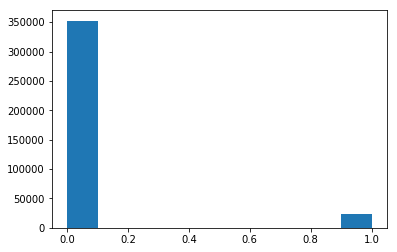

In [18]:
pred_test=0.6*pred_test_glove+0.4*pred_test_para
pred_test=(pred_test>0.35).astype(int)
plt.hist(pred_test)

In [19]:
test_df['prediction']=pred_test
test_df=test_df.drop(['question_text'],axis=1)
test_df.to_csv("submission.csv",index=False)

# Further thoughts
After I learned some top rank solutions, I think some skills like the followings could be applied to imporve the performance:<br>
1) Simplify the RNN model<br>
2) Keep all the tokens from raw text, that should sacrifice the running speed<br>
3) Ensemble the embeddings by concatenate them instead of averaging them or weighting them. In another words, increase the embedding size.<br>
4) Use variety of stemmer to clean the text<br>